## Librerías

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from tqdm.notebook import tqdm
import nltk
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import pipeline
from nrclex import NRCLex

## Descarga nlp

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rodrigo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [14]:
nlp = spacy.load("es_core_news_lg")

## Ingesta

In [40]:
df = pd.read_parquet("Database/01_bbdd_think_tanks.parquet")
df["FechaPublicacion"] = pd.to_datetime(df["FechaPublicacion"], errors="coerce")

In [41]:
df_pivotes = df[df["Think Tank"] == "Pivotes"].copy()
df_pivotes = df_pivotes[df_pivotes["TextoLimpio"].notnull()]

In [42]:
print(f"Cantidad de publicaciones de Pivotes: {len(df_pivotes)}")

Cantidad de publicaciones de Pivotes: 676


## Frecuencia

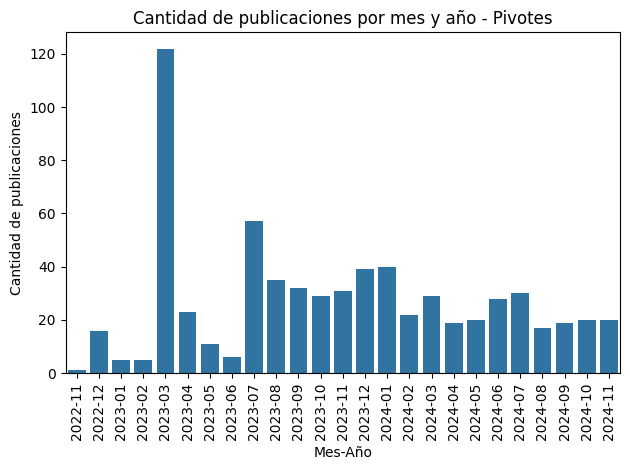

In [43]:
df_pivotes["MesAño"] = df_pivotes["FechaPublicacion"].dt.to_period("M").astype(str)
sns.countplot(data=df_pivotes, x="MesAño", order=sorted(df_pivotes["MesAño"].unique()))
plt.title("Cantidad de publicaciones por mes y año - Pivotes")
plt.xticks(rotation=90)
plt.xlabel("Mes-Año")
plt.ylabel("Cantidad de publicaciones")
plt.tight_layout()
plt.show()

## WordCloud

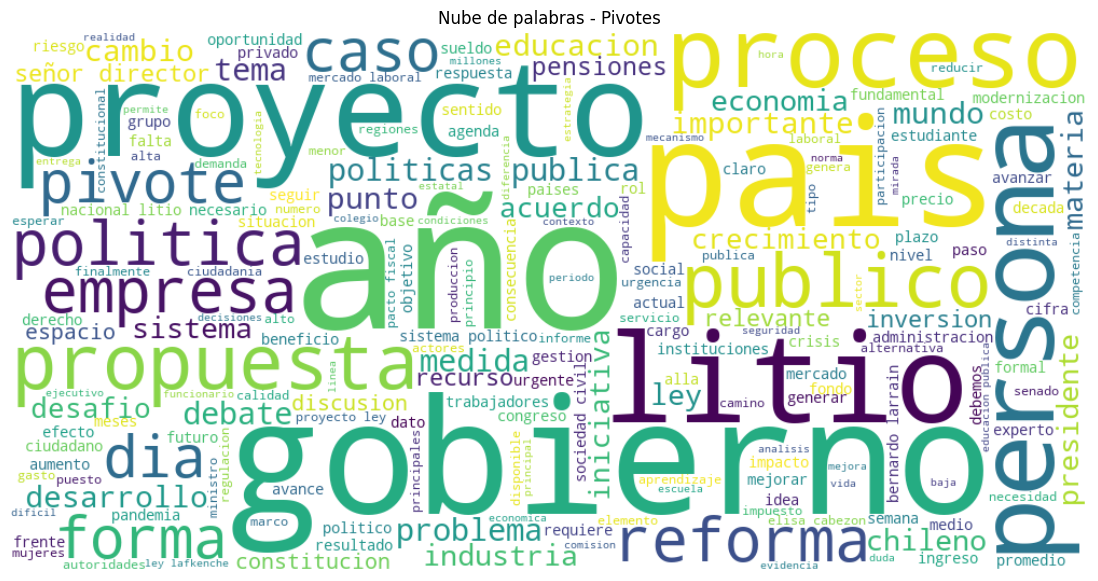

In [44]:
texto_completo = " ".join(df_pivotes["TextoLimpio"].tolist())
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(texto_completo)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras - Pivotes")
plt.show()

## Sentimientos

In [45]:
def obtener_sentimiento(text):
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except:
        return None

tqdm.pandas()
df_pivotes["sentimiento"] = df_pivotes["TextoLimpio"].progress_apply(obtener_sentimiento)

  0%|          | 0/676 [00:00<?, ?it/s]

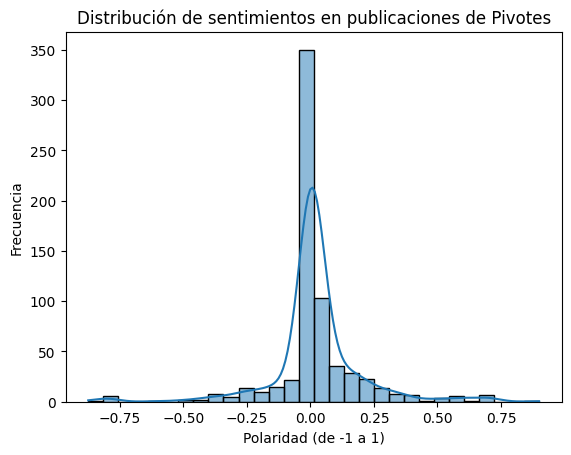

In [46]:
sns.histplot(df_pivotes["sentimiento"], bins=30, kde=True)
plt.title("Distribución de sentimientos en publicaciones de Pivotes")
plt.xlabel("Polaridad (de -1 a 1)")
plt.ylabel("Frecuencia")
plt.show()

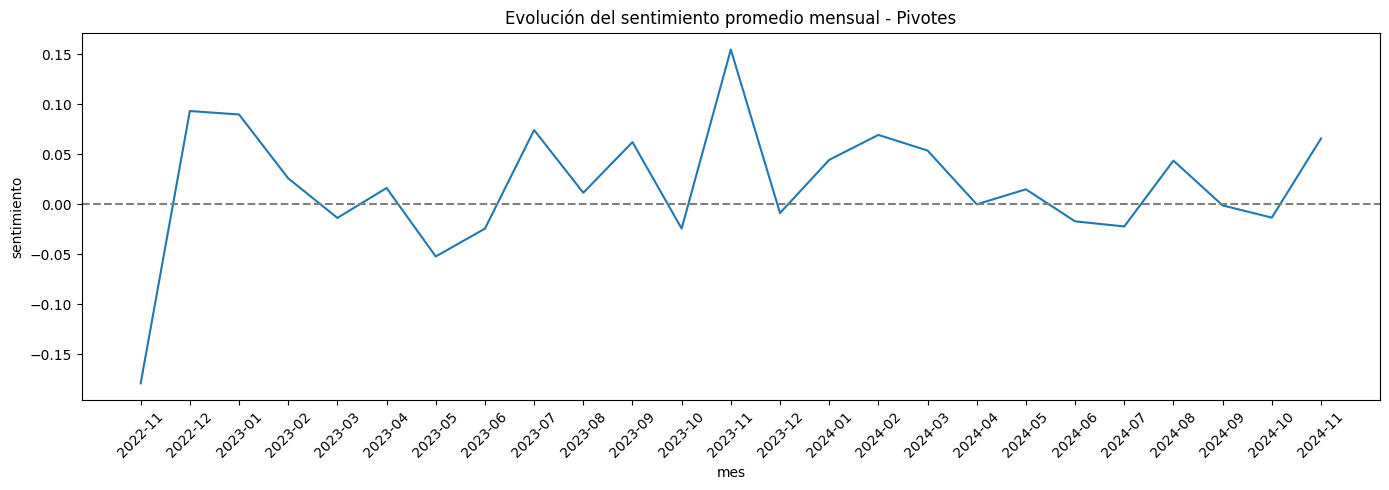

In [47]:
df_pivotes["mes"] = df_pivotes["FechaPublicacion"].dt.to_period("M")
sentimiento_mensual = df_pivotes.groupby("mes")["sentimiento"].mean().reset_index()
sentimiento_mensual["mes"] = sentimiento_mensual["mes"].astype(str)

plt.figure(figsize=(14,5))
sns.lineplot(data=sentimiento_mensual, x="mes", y="sentimiento")
plt.title("Evolución del sentimiento promedio mensual - Pivotes")
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

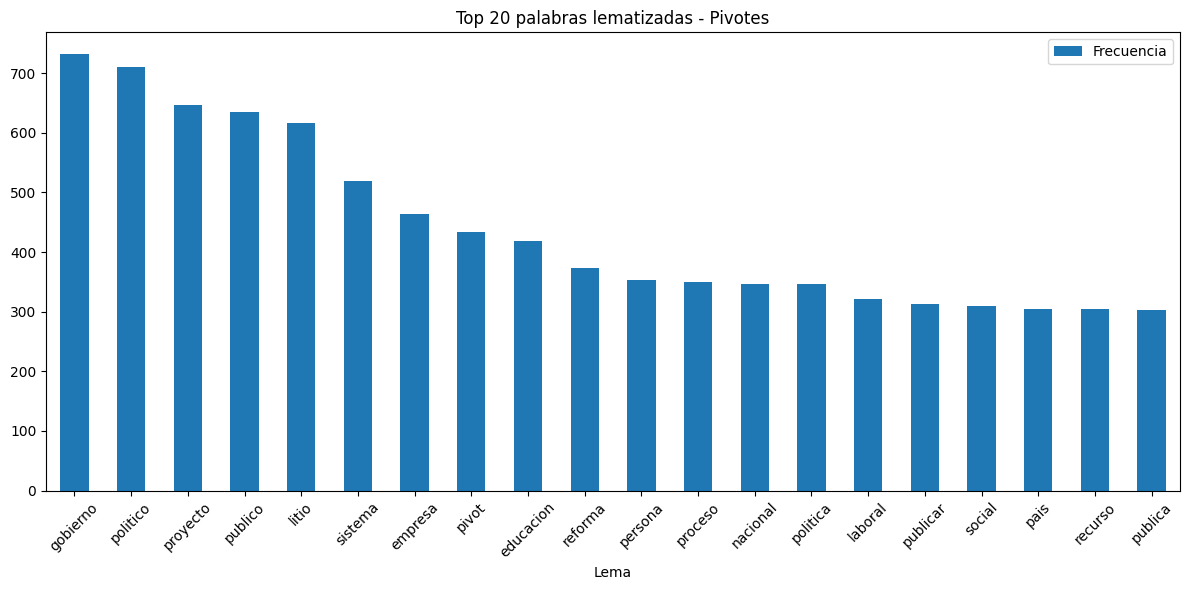

In [48]:
lemmas = []
for doc in tqdm(nlp.pipe(df_pivotes["TextoLimpio"].tolist(), batch_size=50)):
    lemmas += [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_) > 3]

conteo_lemmas = Counter(lemmas)
pd.DataFrame(conteo_lemmas.most_common(20), columns=["Lema", "Frecuencia"]).plot.bar(x="Lema", y="Frecuencia", figsize=(12,6), title="Top 20 palabras lematizadas - Pivotes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
documentos = df_pivotes["TextoLimpio"].tolist()
vectorizer = TfidfVectorizer(ngram_range=(3, 3), stop_words=None)
X = vectorizer.fit_transform(documentos)
tfidf_sum = X.sum(axis=0).A1
features = vectorizer.get_feature_names_out()
sorted_idx = tfidf_sum.argsort()[::-1]
top_trigramas = [features[i] for i in sorted_idx[:20]]

print("Top 20 trigramas por TF-IDF total en Pivotes:")
print(top_trigramas)


Top 20 trigramas por TF-IDF total en Pivotes:
['bernardo larrain disponible', 'entrevista bernardo larrain', 'entrevista elisa cabezon', 'estrategia nacional litio', 'directora evidencia pivotes', 'elisa cabezon disponible', 'empresa nacional litio', 'descarga estudio preparado', 'bernardo larrain matte', 'elisa cabezon directora', 'presidente gabriel boric', 'pivotes elisa cabezon', 'pueblos originarios ecmpo', 'cabezon directora evidencia', 'politicas publicas pivotes', 'evidencia pivotes elisa', 'espacios costeros marinos', 'iniciativa popular norma', 'deudores cae etapa', 'cae etapa pago']


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_8600\1058221627.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_tfidf, x='TF-IDF', y='Trigrama', palette='viridis')


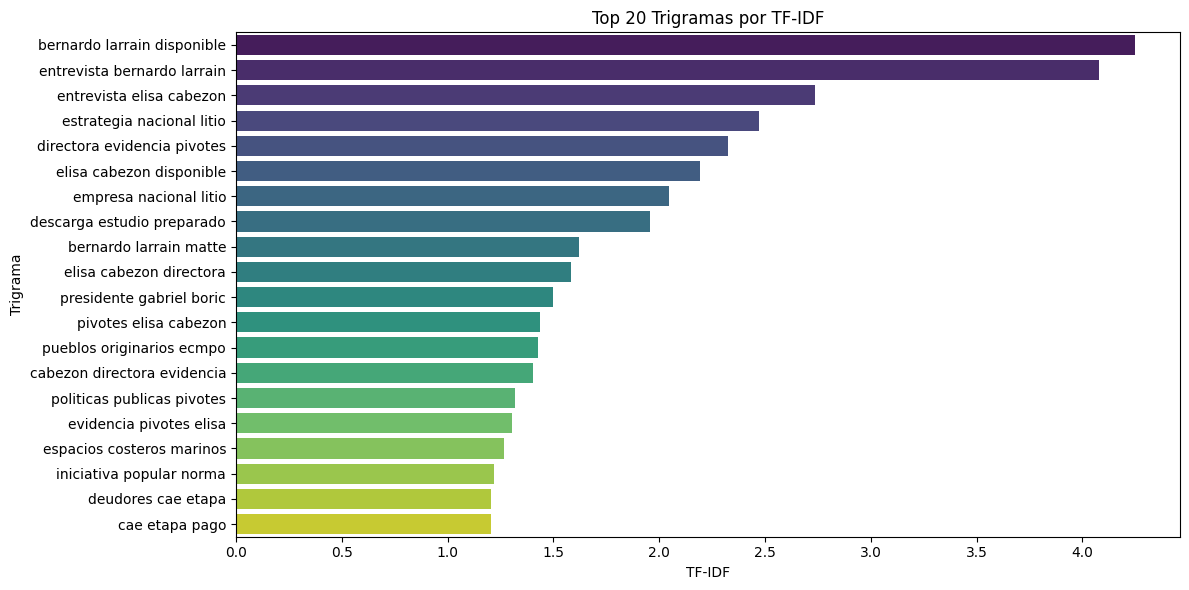

In [50]:
df_tfidf = pd.DataFrame({'Trigrama': top_trigramas, 'TF-IDF': tfidf_sum[sorted_idx[:20]]})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_tfidf, x='TF-IDF', y='Trigrama', palette='viridis')
plt.title('Top 20 Trigramas por TF-IDF')
plt.xlabel('TF-IDF')
plt.ylabel('Trigrama')
plt.tight_layout()
plt.show()

In [51]:
embeddings = np.array([nlp(text).vector for text in tqdm(df_pivotes["TextoLimpio"].tolist())])

  0%|          | 0/676 [00:00<?, ?it/s]

In [52]:
pca = PCA(n_components=2)
reducido = pca.fit_transform(embeddings)

In [53]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_pivotes["cluster"] = kmeans.fit_predict(reducido)

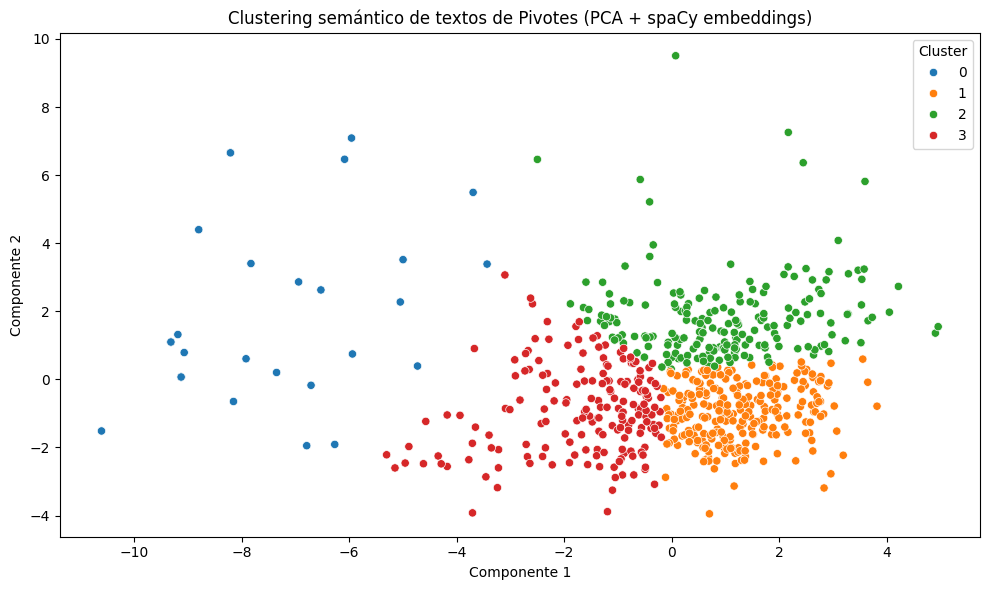

In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=reducido[:,0], y=reducido[:,1], hue=df_pivotes["cluster"], palette="tab10")
plt.title("Clustering semántico de textos de Pivotes (PCA + spaCy embeddings)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [55]:
print("Análisis interpretativo de clusters...")
for i in sorted(df_pivotes["cluster"].unique()):
    subset = df_pivotes[df_pivotes["cluster"] == i]
    top_lemmas = Counter()
    for doc in nlp.pipe(subset["TextoLimpio"].tolist(), batch_size=50):
        top_lemmas.update([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_) > 3])
    print(f"\n--- Cluster {i} ---")
    print("Top términos:", ", ".join([lemma for lemma, _ in top_lemmas.most_common(10)]))
    print("Sentimiento promedio:", round(subset["sentimiento"].mean(), 3))


Análisis interpretativo de clusters...

--- Cluster 0 ---
Top términos: disponible, entrevista, bernardo, larrain, elisa, cabezon, litio, seminario, chileno, plebiscito
Sentimiento promedio: 0.0

--- Cluster 1 ---
Top términos: politico, publico, gobierno, proyecto, sistema, proceso, reforma, educacion, constitucional, publicar
Sentimiento promedio: 0.021

--- Cluster 2 ---
Top términos: litio, empresa, laboral, pensión, mercado, formal, trabajador, sistema, chileno, privado
Sentimiento promedio: 0.028

--- Cluster 3 ---
Top términos: litio, gobierno, proyecto, empresa, pivot, presidente, nacional, politico, director, publico
Sentimiento promedio: 0.026


In [56]:
df_pivotes["mes"] = df_pivotes["FechaPublicacion"].dt.to_period("M")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=30)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_pivotes["TextoLimpio"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df["mes"] = df_pivotes["mes"].astype(str).values


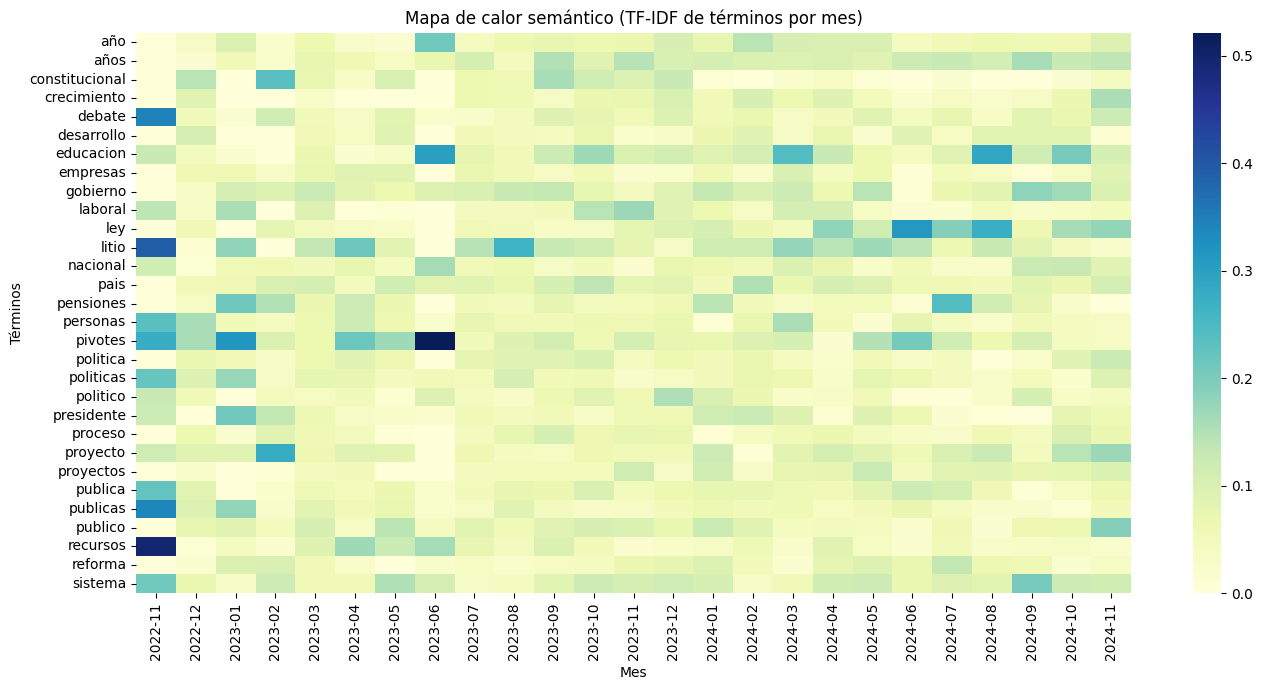

In [57]:
heatmap_data = tfidf_df.groupby("mes").mean().fillna(0)
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data.T, cmap="YlGnBu", cbar=True)
plt.title("Mapa de calor semántico (TF-IDF de términos por mes)")
plt.xlabel("Mes")
plt.ylabel("Términos")
plt.tight_layout()
plt.show()

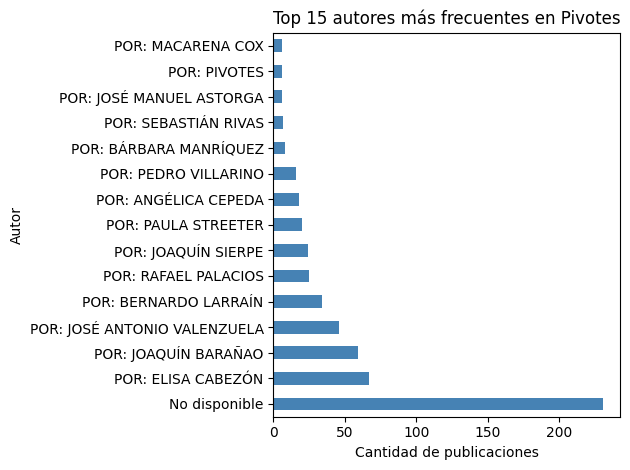

In [62]:
autores_activos = df_pivotes["Autor"].value_counts().head(15)
autores_activos.plot(kind="barh", color="steelblue")
plt.title("Top 15 autores más frecuentes en Pivotes")
plt.xlabel("Cantidad de publicaciones")
plt.tight_layout()
plt.show()

In [67]:
def clasificar_emocion(score):
    if score is None:
        return "neutro"
    elif score > 0.1:
        return "positivo"
    elif score < -0.1:
        return "negativo"
    else:
        return "neutro"

df_pivotes["emocion_textblob"] = df_pivotes["sentimiento"].apply(clasificar_emocion)

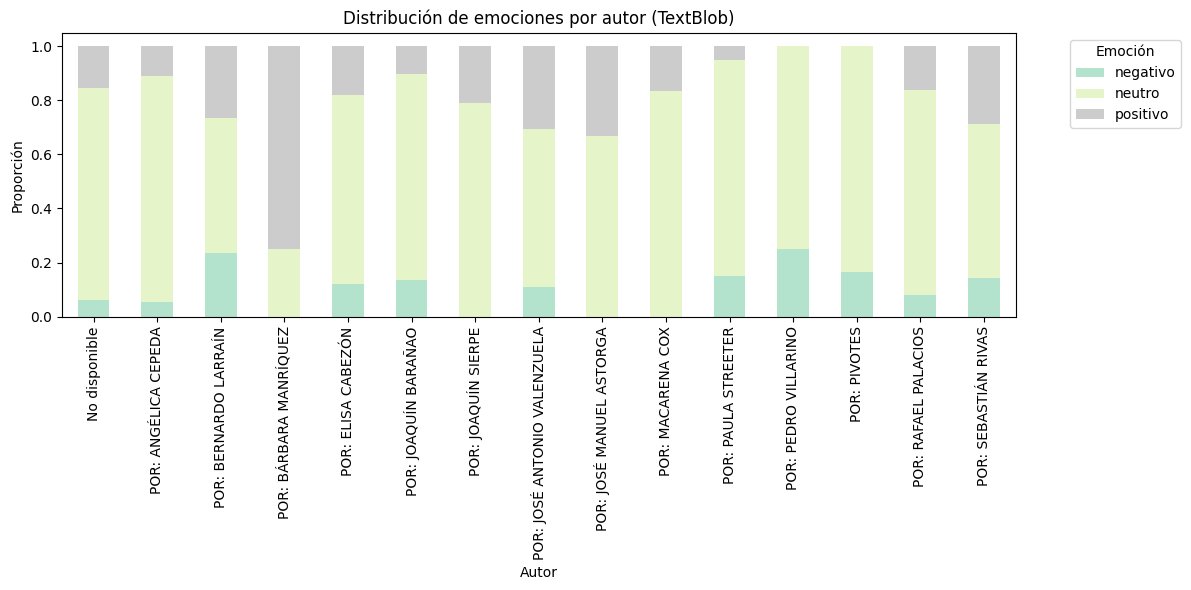

In [68]:
autores_top = df_pivotes["Autor"].value_counts().head(15).index
df_autores_emocion = df_pivotes[df_pivotes["Autor"].isin(autores_top)]
graf_autores = pd.crosstab(df_autores_emocion["Autor"], df_autores_emocion["emocion_textblob"], normalize='index')
graf_autores.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Pastel2")
plt.title("Distribución de emociones por autor (TextBlob)")
plt.ylabel("Proporción")
plt.legend(title="Emoción", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

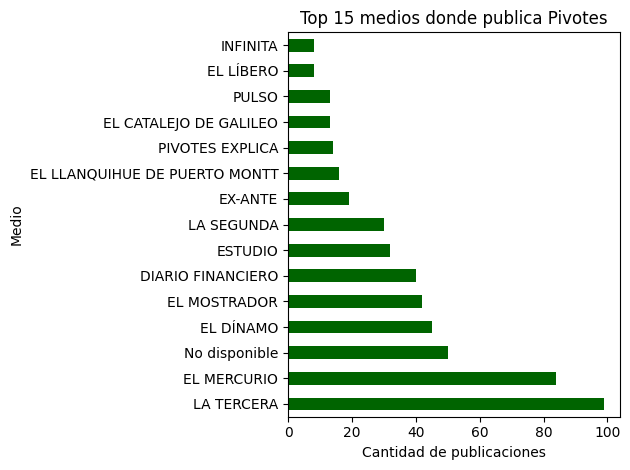

In [63]:
medios_visibles = df_pivotes["Medio"].value_counts().head(15)
medios_visibles.plot(kind="barh", color="darkgreen")
plt.title("Top 15 medios donde publica Pivotes")
plt.xlabel("Cantidad de publicaciones")
plt.tight_layout()
plt.show()

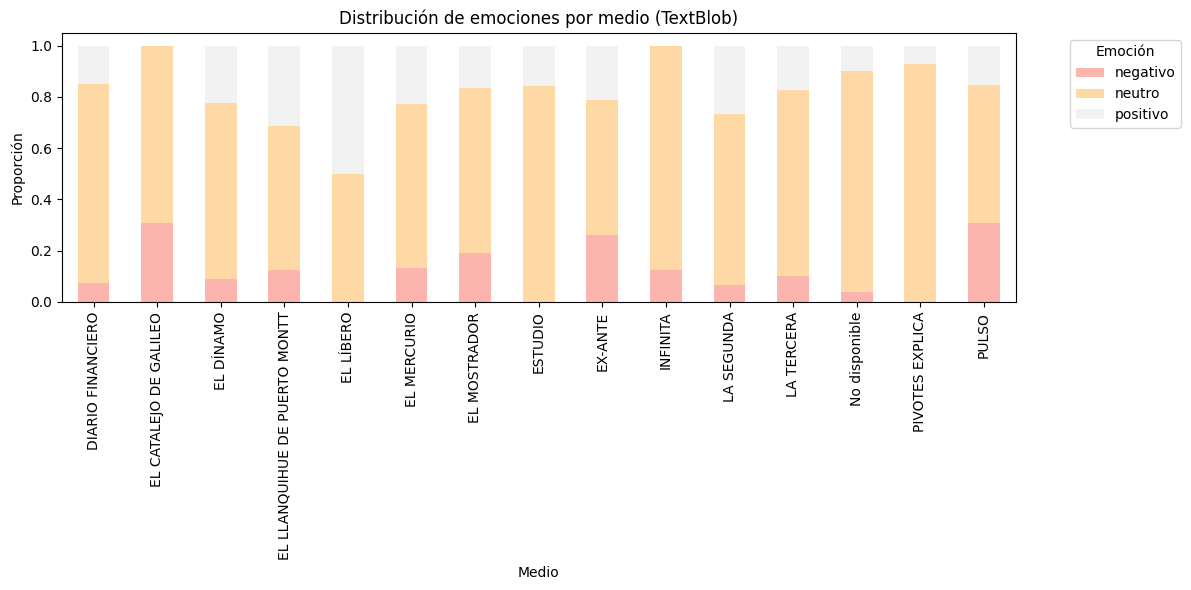

In [69]:
df_medios_emocion = df_pivotes[df_pivotes["Medio"].isin(medios_visibles.index)]
graf_medios = pd.crosstab(df_medios_emocion["Medio"], df_medios_emocion["emocion_textblob"], normalize='index')
graf_medios.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Pastel1")
plt.title("Distribución de emociones por medio (TextBlob)")
plt.ylabel("Proporción")
plt.legend(title="Emoción", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()